# 03 - Model Development

This notebook trains three regression models — Random Forest, XGBoost, and a Neural Network — and compares their performance on the validation set to select the best model for our flat price prediction task.

## 1. Imports and Data Loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

np.random.seed(42)

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
X_train = np.load('../data/processed/X_train.npy')
X_val = np.load('../data/processed/X_val.npy')
y_train = np.load('../data/processed/y_train.npy')
y_val = np.load('../data/processed/y_val.npy')

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")

Training set: (80000, 20)
Validation set: (20000, 20)


## 2. Evaluation Metrics

We define a helper function to compute RMSE, MAE, and R² for each model consistently.

In [3]:
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{model_name} Performance:")
    print(f"  RMSE: {rmse:,.2f}")
    print(f"  MAE:  {mae:,.2f}")
    print(f"  R²:   {r2:.4f}")
    
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

## 3. Random Forest

We start with a Random Forest regressor — an ensemble of decision trees that naturally handles non-linear relationships.

In [4]:
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)

print("Training Random Forest...")
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_val)
rf_results = evaluate_model(y_val, rf_pred, "Random Forest")

Training Random Forest...

Random Forest Performance:
  RMSE: 405,460.39
  MAE:  262,684.72
  R²:   0.9950


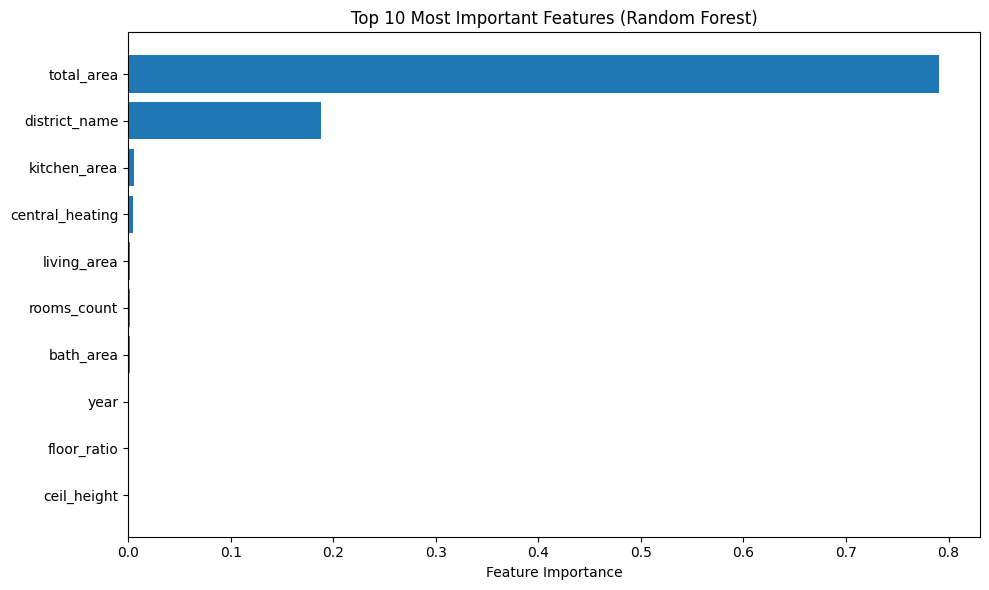

In [5]:
feature_names = open('../data/processed/feature_names.txt').read().split('\n')
importances = rf_model.feature_importances_

indices = np.argsort(importances)[::-1][:10]

plt.figure(figsize=(10, 6))
plt.barh(range(10), importances[indices])
plt.yticks(range(10), [feature_names[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Top 10 Most Important Features (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 4. XGBoost

XGBoost is a gradient boosting method where each new tree corrects the errors of the previous ones. It is widely used for structured/tabular data.

In [6]:
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    random_state=42,
    n_jobs=-1
)

print("Training XGBoost...")
xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_val)
xgb_results = evaluate_model(y_val, xgb_pred, "XGBoost")

Training XGBoost...

XGBoost Performance:
  RMSE: 327,303.12
  MAE:  179,583.47
  R²:   0.9967


## 5. Neural Network

We train a multi-layer perceptron with three hidden layers (128 → 64 → 32 neurons) and Dropout for regularisation. Early stopping is used to prevent overfitting.

In [7]:
input_dim = X_train.shape[1]

nn_model = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

nn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,057 (51.00 KB)

 Trainable params: 13,057 (51.00 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
nn_model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
print("Training Neural Network...")
history = nn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

nn_pred = nn_model.predict(X_val, verbose=0).flatten()
nn_results = evaluate_model(y_val, nn_pred, "Neural Network")

Training Neural Network...
Epoch 1/100


In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Model Loss During Training')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Model MAE During Training')
plt.legend()

plt.tight_layout()
plt.show()

## 6. Model Comparison

We compare all three models on the validation set using the same metrics.

In [ ]:
results_df = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'Neural Network'],
    'RMSE': [rf_results['RMSE'], xgb_results['RMSE'], nn_results['RMSE']],
    'MAE': [rf_results['MAE'], xgb_results['MAE'], nn_results['MAE']],
    'R²': [rf_results['R2'], xgb_results['R2'], nn_results['R2']]
})

print("MODEL COMPARISON ON VALIDATION SET")
print("=" * 60)
print(results_df.to_string(index=False))
print("=" * 60)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].bar(results_df['Model'], results_df['RMSE'])
axes[0].set_ylabel('RMSE')
axes[0].set_title('RMSE Comparison (Lower is Better)')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(results_df['Model'], results_df['MAE'])
axes[1].set_ylabel('MAE')
axes[1].set_title('MAE Comparison (Lower is Better)')
axes[1].tick_params(axis='x', rotation=45)

axes[2].bar(results_df['Model'], results_df['R²'])
axes[2].set_ylabel('R²')
axes[2].set_title('R² Comparison (Higher is Better)')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 7. Save Models

We save all trained models and record the name of the best-performing one for use in the evaluation notebook.

In [ ]:
joblib.dump(rf_model, '../models/random_forest.pkl')
joblib.dump(xgb_model, '../models/xgboost.pkl')
nn_model.save('../models/neural_network.keras')

print("Models saved:")
print("  - ../models/random_forest.pkl")
print("  - ../models/xgboost.pkl")
print("  - ../models/neural_network.keras")

In [ ]:
best_model_idx = results_df['RMSE'].idxmin()
best_model_name = results_df.loc[best_model_idx, 'Model']

with open('../models/best_model.txt', 'w') as f:
    f.write(best_model_name)

print(f"Best performing model: {best_model_name}")
print(f"Validation RMSE: {results_df.loc[best_model_idx, 'RMSE']:,.2f}")